## Library Import and Configuration
Can add

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [ ]:
!pip install --quiet "duckdb<1.1" jupysql duckdb-engine pandas

In [ ]:
import duckdb
import pandas as pd
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Load "tables"


In [ ]:



exposures = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["exposures"]))
features = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["features"]))
orders = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["orders"]))
emails = pd.read_csv(_generate_drive_link(url=TABLE_MAPPING["emails"]))

Step 1:

In [ ]:
%%sql df <<

With audience as (
    SELECT
    e.user_id,
    e.variant_name,
    CAST(e.exposed_at as TIMESTAMP) as exposed_at,
    e.days_since_signup,

    ROW_NUMBER() OVER (PARTITION BY e.user_id ORDER BY e.exposed_at) as exposure_seq

    FROM exposures e

    WHERE 1=1
    # AND e.user_id == 648098

)
,feat as (
  SELECT DISTINCT
  f.user_id,
  f.created_at,
  f.loyalty_points,
  f.sign_up_incentive

  FROM features f

  WHERE 1=1
  # AND f.user_id == 648098

)
,order_info as (
  SELECT DISTINCT
  o.user_id,
  CAST(o.occurred_at as TIMESTAMP) as occurred_at,
  o.revenue

  FROM orders o

  WHERE 1=1

)
, customer_profile as (
  select
      a.user_id,
      a.variant_name,
      a.exposed_at,
      a.days_since_signup,

      MAX(f.loyalty_points) as loyalty_points,
      MAX(f.sign_up_incentive) as sign_up_incentive

  FROM audience a
  LEFT JOIN feat f ON a.user_id = f.user_id
  AND DATE_TRUNC('day',CAST(a.exposed_at AS TIMESTAMP)) = DATE_TRUNC('day',CAST(f.created_at  AS TIMESTAMP))

  WHERE 1=1
  AND a.exposure_seq == 1

  GROUP BY 1,2,3,4
)
,orders_agg as (
select DISTINCT
      a.user_id,

      COUNT(o.user_id) as overall_orders,
      SUM(o.revenue) as overall_revenue,

      COUNT(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 THEN o.user_id END) as prev_orders_7d,
      COUNT(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 * 2.00 THEN o.user_id END) as prev_orders_14d,
      COUNT(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 * 4.00 THEN o.user_id END) as prev_orders_28d,

      COUNT(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 THEN o.user_id END) as next_orders_7d,
      COUNT(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 * 2.00 THEN o.user_id END) as next_orders_14d,

      SUM(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 THEN o.revenue END) as prev_revenue_7d,
      SUM(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 * 2.00 THEN o.revenue END) as prev_revenue_14d,

      SUM(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 THEN o.revenue END) as next_revenue_7d,
      SUM(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 * 2.00 THEN o.revenue END) as next_revenue_14d,

      COUNT(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) < CAST(o.occurred_at  AS TIMESTAMP) THEN o.user_id END) as after_exposure_orders,
       COUNT(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) > CAST(o.occurred_at  AS TIMESTAMP) THEN o.user_id END) as before_exposure_orders,

      SUM(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) < CAST(o.occurred_at  AS TIMESTAMP) THEN o.revenue END) as after_exposure_revenue,
       SUM(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) > CAST(o.occurred_at  AS TIMESTAMP) THEN o.revenue END) as before_exposure_revenue



  FROM customer_profile a

  LEFT JOIN order_info o ON a.user_id = o.user_id
  # AND (
  #       CAST(a.exposed_at AS TIMESTAMP) < CAST(o.occurred_at  AS TIMESTAMP)
  #       OR
  #       CAST(a.exposed_at AS TIMESTAMP) > CAST(o.occurred_at  AS TIMESTAMP)
  # )
GROUP BY 1
)
,clicks_agg as (
select DISTINCT
      a.user_id,

      COUNT(e.user_id) as overall_clicks,

      COUNT(CASE WHEN DATE_DIFF('second',CAST(e.occurred_at as TIMESTAMP),a.exposed_at) BETWEEN 0 AND 604800 THEN e.user_id END) as prev_clicks_7d,
      COUNT(CASE WHEN DATE_DIFF('second',CAST(e.occurred_at as TIMESTAMP),a.exposed_at) BETWEEN 0 AND 604800 * 2.00 THEN e.user_id END) as prev_clicks_14d,

      COUNT(CASE WHEN DATE_DIFF('second',a.exposed_at,CAST(e.occurred_at as TIMESTAMP)) BETWEEN 0 AND 604800 THEN e.user_id END) as next_clicks_7d,
      COUNT(CASE WHEN DATE_DIFF('second',a.exposed_at,CAST(e.occurred_at as TIMESTAMP)) BETWEEN 0 AND 604800 * 2.00 THEN e.user_id END) as next_clicks_14d,

       COUNT(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) < CAST(e.occurred_at  AS TIMESTAMP) THEN e.user_id END) as after_exposure_clicks,
       COUNT(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) > CAST(e.occurred_at  AS TIMESTAMP) THEN e.user_id END) as before_exposure_clicks


  FROM customer_profile a

  LEFT JOIN emails e
  ON a.user_id = e.user_id


  GROUP BY 1

      )
SELECT
cp.user_id,
cp.variant_name,
cp.exposed_at,
cp.days_since_signup,
cp.loyalty_points,
cp.sign_up_incentive,

cl.overall_clicks,
og.overall_orders,
og.overall_revenue,

og.before_exposure_orders,
og.after_exposure_orders,

og.before_exposure_revenue,
og.after_exposure_revenue,

cl.before_exposure_clicks,
cl.after_exposure_clicks,

IF(og.next_orders_7d >= 1, 1,0) AS order_conversion_7d,
IF(og.next_orders_14d >= 1, 1,0) AS order_conversion_14d,

cl.prev_clicks_7d,
cl.prev_clicks_14d,
cl.next_clicks_7d,
cl.next_clicks_14d,

og.prev_orders_7d,
og.prev_orders_14d,
og.prev_orders_28d,
og.next_orders_7d,
og.next_orders_14d,

og.prev_revenue_7d,
og.prev_revenue_14d,
og.next_revenue_7d,
og.next_revenue_14d

FROM customer_profile cp

LEFT JOIN orders_agg og on cp.user_id = og.user_id
LEFT JOIN clicks_agg cl on cp.user_id = cl.user_id

WHERE 1=1 --AND cp.user_id == 8182

# SELECT * FROM orders_agg

In [ ]:
%%sql customer_profile <<

With audience as (
    SELECT
    e.user_id,
    e.variant_name,
    CAST(e.exposed_at as TIMESTAMP) as exposed_at,
    e.days_since_signup,

    ROW_NUMBER() OVER (PARTITION BY e.user_id ORDER BY e.exposed_at) as exposure_seq

    FROM exposures e

    WHERE 1=1
    # AND e.user_id == 648098

)
,feat as (
  SELECT DISTINCT
  f.user_id,
  f.created_at,
  f.loyalty_points,
  f.sign_up_incentive

  FROM features f

  WHERE 1=1
  # AND f.user_id == 648098

)
,order_info as (
  SELECT DISTINCT
  o.user_id,
  CAST(o.occurred_at as TIMESTAMP) as occurred_at,
  o.revenue

  FROM orders o

  WHERE 1=1

)
, customer_profile as (
  select
      a.user_id,
      a.variant_name,
      a.exposed_at,
      a.days_since_signup,

      MAX(f.loyalty_points) as loyalty_points,
      MAX(f.sign_up_incentive) as sign_up_incentive

  FROM audience a
  LEFT JOIN feat f ON a.user_id = f.user_id
  AND DATE_TRUNC('day',CAST(a.exposed_at AS TIMESTAMP)) = DATE_TRUNC('day',CAST(f.created_at  AS TIMESTAMP))

  WHERE 1=1
  AND a.exposure_seq == 1

  GROUP BY 1,2,3,4
)
,orders_agg as (
select DISTINCT
      a.user_id,

      COUNT(o.user_id) as overall_orders,
      SUM(o.revenue) as overall_revenue,

      COUNT(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 THEN o.user_id END) as prev_orders_7d,
      COUNT(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 * 2.00 THEN o.user_id END) as prev_orders_14d,
      COUNT(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 * 4.00 THEN o.user_id END) as prev_orders_28d,

      COUNT(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 THEN o.user_id END) as next_orders_7d,
      COUNT(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 * 2.00 THEN o.user_id END) as next_orders_14d,

      SUM(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 THEN o.revenue END) as prev_revenue_7d,
      SUM(CASE WHEN DATE_DIFF('second',o.occurred_at,a.exposed_at) BETWEEN 0 AND 604800 * 2.00 THEN o.revenue END) as prev_revenue_14d,

      SUM(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 THEN o.revenue END) as next_revenue_7d,
      SUM(CASE WHEN DATE_DIFF('second',a.exposed_at,o.occurred_at) BETWEEN 0 AND 604800 * 2.00 THEN o.revenue END) as next_revenue_14d,

      COUNT(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) < CAST(o.occurred_at  AS TIMESTAMP) THEN o.user_id END) as after_exposure_orders,
       COUNT(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) > CAST(o.occurred_at  AS TIMESTAMP) THEN o.user_id END) as before_exposure_orders,

      SUM(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) < CAST(o.occurred_at  AS TIMESTAMP) THEN o.revenue END) as after_exposure_revenue,
       SUM(CASE WHEN CAST(a.exposed_at AS TIMESTAMP) > CAST(o.occurred_at  AS TIMESTAMP) THEN o.revenue END) as before_exposure_revenue



  FROM customer_profile a

  LEFT JOIN order_info o ON a.user_id = o.user_id
  AND (
        CAST(o.occurred_at  AS TIMESTAMP) < CAST(a.exposed_at AS TIMESTAMP)
  )
GROUP BY 1
)
SELECT
cp.user_id,
cp.variant_name,
cp.exposed_at,
cp.days_since_signup,
cp.loyalty_points,
cp.sign_up_incentive,

og.overall_orders,
og.overall_revenue,

og.before_exposure_orders,
og.after_exposure_orders,

og.before_exposure_revenue,
og.after_exposure_revenue,


IF(og.next_orders_7d >= 1, 1,0) AS order_conversion_7d,
IF(og.next_orders_14d >= 1, 1,0) AS order_conversion_14d,

og.prev_orders_7d,
og.prev_orders_14d,
og.prev_orders_28d,
og.next_orders_7d,
og.next_orders_14d,

og.prev_revenue_7d,
og.prev_revenue_14d,
og.next_revenue_7d,
og.next_revenue_14d

FROM customer_profile cp

LEFT JOIN orders_agg og on cp.user_id = og.user_id

WHERE 1=1

In [ ]:
df.head()

,user_id,variant_name,exposed_at,days_since_signup,loyalty_points,sign_up_incentive,overall_clicks,overall_orders,overall_revenue,before_exposure_orders,...,next_clicks_14d,prev_orders_7d,prev_orders_14d,prev_orders_28d,next_orders_7d,next_orders_14d,prev_revenue_7d,prev_revenue_14d,next_revenue_7d,next_revenue_14d
0,76122,20-percent,2023-07-26 21:37:19.520,369.0,2125.0,None,8,2,990.00,0,...,0,0,0,0,0,1,NaN,NaN,NaN,455.00
1,271626,10-percent,2023-07-26 22:23:43.180,6.0,NaN,Free Shipping,0,2,419.98,0,...,0,0,0,0,1,1,NaN,NaN,330.99,330.99
2,428739,10-percent,2023-07-27 13:20:31.942,59.0,NaN,Free Shipping,2,0,NaN,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,191798,10-percent,2023-07-27 17:04:05.524,1.0,NaN,None,0,0,NaN,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,174980,10-percent,2023-07-27 11:49:32.649,130.0,NaN,Free Shipping,0,1,138.00,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


In [ ]:
percentiles = [5, 15, 25, 50, 75, 90, 95, 99]

# Calculate percentile thresholds for orders and revenue
orders_percentile = dict(zip(
    np.percentile(customer_profile[customer_profile['overall_orders'] >= 1]['overall_orders'], percentiles), percentiles
))
revenue_percentile = dict(zip(
    np.percentile(customer_profile[customer_profile['overall_revenue'] >= 1]['overall_revenue'], percentiles), percentiles
))


loyalty_points_percentile = dict(zip(
    np.percentile(customer_profile[customer_profile['loyalty_points'] >= 1]['loyalty_points'], percentiles), percentiles
))

# Sort percentiles by thresholds for easier comparison
orders_thresholds = sorted(orders_percentile.items())
revenue_thresholds = sorted(revenue_percentile.items())
loyalty_points_thresholds = sorted(loyalty_points_percentile.items())



def get_order_percentile(value):
    if value < 1:
        return 0  # For values below 1
    for threshold, percentile in orders_thresholds:
        if value <= threshold:
            return percentile
    return 100  # Above all thresholds

# Function to determine percentile range for revenue
def get_revenue_percentile(value):
    if value < 1:
        return 0  # For values below 1
    for threshold, percentile in revenue_thresholds:
        if value <= threshold:
            return percentile
    return 100  # Above all thresholds


def get_points_percentile(value):
    if value < 1:
        return 0  # For values below 1
    for threshold, percentile in loyalty_points_thresholds:
        if value <= threshold:
            return percentile
    return 100  # Above all thresholds

def classify_user(order_rank, revenue_rank):
    # Early Life Cycle Users
    if order_rank == 0 or revenue_rank == 0:
        return "0.Early Life Cycle"

    # High Value Users
    if order_rank >= 75 and revenue_rank >= 75:
        return "3.High Value User"

    # Medium Value Users
    if (25 <= order_rank < 75) or (25 <= revenue_rank < 75):
        return "2.Medium Value User"

    # Low Value Users
    return "1.Low Value User"

#############################################################

def get_loyalty_tier(points, thresholds):
    if points == 0:
      return "0.no tier"

    elif points >= loyalty_points_thresholds[3][0] and points <= loyalty_points_thresholds[4][0]:
      return "3.Gold"
    elif points >= loyalty_points_thresholds[2][0] and points < loyalty_points_thresholds[3][0]:
      return "2.Silver"
    elif points <= loyalty_points_thresholds[0][0]:
      return "1.Bronze"
    else:
        return "4.Platinum"

# Combine user category with loyalty tier
# df['combined_category'] = df['user_category'].astype(str) + " - " + df['loyalty_tier']

# Display results
# print(df[['user_id', 'user_category', 'loyalty_points', 'loyalty_tier', 'combined_category']])


customer_profile['order_rank'] = customer_profile['overall_orders'].fillna(0).apply(get_order_percentile)
customer_profile['revenue_rank'] = customer_profile['overall_revenue'].fillna(0).apply(get_revenue_percentile)
customer_profile['revenue_rank'] = customer_profile['overall_revenue'].fillna(0).apply(get_revenue_percentile)

customer_profile['user_category'] = customer_profile.apply(lambda row: classify_user(row['order_rank'], row['revenue_rank']), axis=1)
# customer_profile['loyalty_tier'] = customer_profile['loyalty_points'].apply(get_points_percentile)

customer_profile['loyalty_tier'] = customer_profile['loyalty_points'].fillna(0).astype(float).apply(lambda row: get_loyalty_tier(row,loyalty_points_thresholds))


df = df.merge(customer_profile[['user_id','user_category','loyalty_tier']],left_on='user_id',right_on='user_id',how='left')

# # Display the result
# temp = df[['variant_name','user_id', 'loyalty_points','overall_orders','overall_revenue','user_category','loyalty_tier']]



In [ ]:
temp = df[['variant_name','user_id','user_category','loyalty_tier','sign_up_incentive','order_conversion_7d']]



# temp[temp['user_category'] == '0.Early Life Cycle'].groupby(['variant_name','sign_up_incentive','loyalty_tier'])['user_id'].count().unstack(['loyalty_tier']).reset_index()
temp[temp['user_category'] == '0.Early Life Cycle'].groupby(['variant_name','sign_up_incentive','loyalty_tier'])['order_conversion_7d'].sum().unstack(['loyalty_tier']).reset_index().fillna(0)


loyalty_tier,variant_name,sign_up_incentive,0.no tier,1.Bronze,2.Silver,3.Gold,4.Platinum
0,10-percent,Free Shipping,162,7,20,18,31
1,20-percent,Free Shipping,201,12,17,12,36
2,zero,Free Shipping,156,9,10,18,22


In [ ]:
# %%sql

# With audience as (
#     SELECT
#     e.user_id,
#     e.variant_name,
#     CAST(e.exposed_at as TIMESTAMP) as exposed_at,
#     e.days_since_signup,

#     ROW_NUMBER() OVER (PARTITION BY e.user_id ORDER BY e.exposed_at) as exposure_seq

#     FROM exposures e

#     WHERE 1=1
#     # AND e.user_id == 648098

# )
# ,feat as (
#   SELECT DISTINCT
#   f.user_id,
#   f.created_at,
#   f.loyalty_points,
#   f.sign_up_incentive

#   FROM features f

#   WHERE 1=1
#   # AND f.user_id == 648098

# )
#   SELECT DISTINCT
#   # o.user_id,

#   variant_name,
#   COUNT(o.user_id) as overall_orders,
#   # STDEV(o.revenue) as overall_revenue_std,
#   AVG(o.revenue) as avg_revenue,

#   approx_quantile(o.revenue, 0.1) as p_10_,
#   approx_quantile(o.revenue, 0.25) as p_25_,
#   approx_quantile(o.revenue, 0.5) as median_revenue,
#   approx_quantile(o.revenue, 0.75) as p_75_,
#   approx_quantile(o.revenue, 0.90) as p_90_,
#   approx_quantile(o.revenue, 0.95) as p_95_,
#   approx_quantile(o.revenue, 0.99) as p_99_,

#   FROM orders o
#   INNER JOIN audience a on o.user_id = a.user_id

# LEFT JOIN feat f ON f.user_id

#   GROUP BY 1


In [ ]:
df.groupby(['user_category','loyalty_tier'])['user_id'].count().unstack(['loyalty_tier'])

loyalty_tier,0.no tier,1.Bronze,2.Silver,3.Gold,4.Platinum
user_category,,,,,
0.Early Life Cycle,25136,234,1032,1021,1871
1.Low Value User,90,17,5,1,108
2.Medium Value User,203,4,181,43,91
3.High Value User,298,8,58,207,130


In [ ]:
df['sign_up_incentive'] = df['sign_up_incentive'].fillna('No Shipping')

df['sign_up_incentive'] .value_counts()

,count
sign_up_incentive,
No Shipping,17435
Free Shipping,13303


In [ ]:
# df.groupby(['variant_name'])

In [ ]:
# Oberervable effect on conversion and reveue based on cohorts

#20% coupon code has an elongagted elasticity curve which can be observed in 14 day window too, have to check if 20% coupon ROI is better.
# 0% users historically have more orders per user and revenue

agg_ = {'user_id':'count',
          'overall_revenue':'sum',
          'order_conversion_7d':'sum',
          # 'order_conversion_14d':'sum',
          'prev_clicks_7d': 'sum',
          'prev_clicks_14d': 'sum',
          'next_clicks_7d': 'sum',
          'next_clicks_14d': 'sum',
          'prev_orders_7d': 'sum',
          'prev_orders_14d': 'sum',
          'next_orders_7d': 'sum',
          'next_orders_14d': 'sum',
          'prev_revenue_7d': 'sum',
          'prev_revenue_14d': 'sum',
          'next_revenue_7d': 'sum',
          'next_revenue_14d': 'sum',
          'before_exposure_orders': 'sum',
          'after_exposure_orders': 'sum',
          'before_exposure_clicks': 'sum',
          'after_exposure_clicks': 'sum',
          'before_exposure_revenue': 'sum',
          'after_exposure_revenue': 'sum'
          }

dim = ['variant_name','user_category']
observed_effect_df = df.groupby(dim).agg(agg_).reset_index()


observed_effect_df['overall_revenue_per_user'] = observed_effect_df['overall_revenue'] / observed_effect_df['user_id']
observed_effect_df['conversion_perc_7d'] = observed_effect_df['order_conversion_7d'] / observed_effect_df['user_id']
# observed_effect_df['conversion_perc_14d'] = observed_effect_df['order_conversion_14d'] / observed_effect_df['user_id']


observed_effect_df['prev_14d_avg_clicks_to_order'] = observed_effect_df['prev_clicks_7d'] / observed_effect_df['prev_orders_7d']
observed_effect_df['prev_7d_avg_clicks_to_order'] = observed_effect_df['prev_clicks_14d'] / observed_effect_df['prev_orders_14d']

observed_effect_df['next_14d_avg_clicks_to_order'] = observed_effect_df['next_clicks_7d'] / observed_effect_df['next_orders_7d']
observed_effect_df['next_7d_avg_clicks_to_order'] = observed_effect_df['next_clicks_14d'] / observed_effect_df['next_orders_14d']



observed_effect_df['prev_14d_avg_orders'] = observed_effect_df['prev_orders_14d'] / observed_effect_df['user_id']
observed_effect_df['prev_7d_avg_orders'] = observed_effect_df['prev_orders_7d'] / observed_effect_df['user_id']

observed_effect_df['next_14d_avg_orders'] = observed_effect_df['next_orders_14d'] / observed_effect_df['user_id']
observed_effect_df['next_7d_avg_orders'] = observed_effect_df['next_orders_7d'] / observed_effect_df['user_id']

observed_effect_df['prev_14d_avg_revenue'] = observed_effect_df['prev_revenue_14d'] / observed_effect_df['user_id']
observed_effect_df['prev_7d_avg_revenue'] = observed_effect_df['prev_revenue_7d'] / observed_effect_df['user_id']

observed_effect_df['next_14d_avg_revenue'] = observed_effect_df['next_revenue_14d'] / observed_effect_df['user_id']
observed_effect_df['next_7d_avg_revenue'] = observed_effect_df['next_revenue_7d'] / observed_effect_df['user_id']

# cols = ['variant_name',
#         # 'days_since_signup_cat',
#         'user_id',

#         # 'order_conversion_7d',
#         # 'before_exposure_orders','after_exposure_orders',
#         # 'before_exposure_revenue','after_exposure_revenue',
#         # 'before_exposure_clicks','after_exposure_clicks',
#         # 'prev_14d_avg_clicks_to_order',
#         'prev_7d_avg_clicks_to_order',
#         # 'next_14d_avg_clicks_to_order',
#         'next_7d_avg_clicks_to_order',
#         # 'prev_14d_avg_orders',
#         'prev_7d_avg_orders',
#         # 'prev_14d_avg_revenue',
#         # 'prev_7d_avg_revenue',
#         # 'next_14d_avg_orders',
#         'next_7d_avg_orders',
#         # 'next_14d_avg_revenue',
#         'next_7d_avg_revenue',
#         'overall_revenue_per_user',
#         'conversion_perc_7d',
#         'conversion_perc_14d',
#         'next_revenue_7d'
#         ]

cols = [
'variant_name',
         'user_category',
'user_id',
'overall_revenue',
'order_conversion_7d',
# 'order_conversion_14d',
'next_orders_7d',
# 'next_orders_14d',
'next_revenue_7d',
# 'next_revenue_14d'
]

observed_effect_df[cols]


,variant_name,user_category,user_id,overall_revenue,order_conversion_7d,next_orders_7d,next_revenue_7d
0,10-percent,0.Early Life Cycle,9796,190640.13,465,470,74616.72
1,10-percent,1.Low Value User,66,6424.31,9,10,1117.97
2,10-percent,2.Medium Value User,176,24076.18,14,14,1663.36
3,10-percent,3.High Value User,249,63582.58,18,18,2550.10
4,20-percent,0.Early Life Cycle,9662,205648.72,573,580,89157.01
5,20-percent,1.Low Value User,68,7485.28,9,9,1331.96
6,20-percent,2.Medium Value User,166,24007.20,19,20,2979.89
7,20-percent,3.High Value User,224,55509.30,18,18,3218.38
8,zero,0.Early Life Cycle,9836,194796.15,427,432,63787.91
9,zero,1.Low Value User,87,8647.05,5,5,748.99


In [ ]:
observed_effect_df.groupby(['variant_name'])['user_id'].sum()

,user_id
variant_name,
10-percent,10287
20-percent,10120
zero,10331


In [ ]:

df.columns
dim = ['variant_name','user_category','loyalty_tier','sign_up_incentive','order_conversion_14d']

agg_ = {'user_id':'count',
          'overall_revenue':'sum',
          'order_conversion_7d':'sum',
          # 'order_conversion_14d':'sum',
          'prev_clicks_7d': 'sum',
          'prev_clicks_14d': 'sum',
          'next_clicks_7d': 'sum',
          'next_clicks_14d': 'sum',
          'prev_orders_7d': 'sum',
          'prev_orders_14d': 'sum',
          'next_orders_7d': 'sum',
          'next_orders_14d': 'sum',
          'prev_revenue_7d': 'sum',
          'prev_revenue_14d': 'sum',
          'next_revenue_7d': 'sum',
          'next_revenue_14d': 'sum',
          'before_exposure_orders': 'sum',
          'after_exposure_orders': 'sum',
          'before_exposure_clicks': 'sum',
          'after_exposure_clicks': 'sum',
          'before_exposure_revenue': 'sum',
          'after_exposure_revenue': 'sum'
          }
display_agg = ['variant_name','user_category','sign_up_incentive','loyalty_tier','order_conversion_14d',
               'prev_orders_14d','prev_revenue_14d',
               'next_revenue_14d',
               'user_id','before_exposure_revenue','after_exposure_revenue']

observed_effect_df = df.groupby(dim).agg(agg_).reset_index()#.unstack('order_conversion_14d')

observed_effect_df[display_agg]
# loyalty_tier

,variant_name,user_category,sign_up_incentive,loyalty_tier,order_conversion_14d,prev_orders_14d,prev_revenue_14d,next_revenue_14d,user_id,before_exposure_revenue,after_exposure_revenue
0,10-percent,0.Early Life Cycle,Free Shipping,0.no tier,0,0,0.00,0.00,3515,0.00,20336.61
1,10-percent,0.Early Life Cycle,Free Shipping,0.no tier,1,0,0.00,36060.96,232,0.00,38646.57
2,10-percent,0.Early Life Cycle,No Shipping,0.no tier,0,0,0.00,0.00,4381,0.00,33554.65
3,10-percent,0.Early Life Cycle,No Shipping,0.no tier,1,0,0.00,43967.69,275,0.00,47700.71
4,10-percent,0.Early Life Cycle,Free Shipping,1.Bronze,0,0,0.00,0.00,46,0.00,68.99
5,10-percent,0.Early Life Cycle,Free Shipping,1.Bronze,1,0,0.00,944.15,7,0.00,944.15
6,10-percent,0.Early Life Cycle,No Shipping,1.Bronze,0,0,0.00,0.00,26,0.00,113.99
7,10-percent,0.Early Life Cycle,No Shipping,1.Bronze,1,0,0.00,952.97,5,0.00,1199.09
8,10-percent,0.Early Life Cycle,Free Shipping,2.Silver,0,0,0.00,0.00,155,0.00,1743.61
9,10-percent,0.Early Life Cycle,Free Shipping,2.Silver,1,0,0.00,3605.84,23,0.00,3709.83


Our data reveals an interesting pattern of customer tenure, with a notable concentration of customers in the 300-450 range.

We will craft a nuanced customer segmentation that respects both the established customer base and the potential of new customer relationships

Strategy 1: Improve conversion rate of Early life cycle users with no tier

In [ ]:
!pip install causalml

from sklearn.model_selection import train_test_split
from causalml.inference.meta import BaseSRegressor, BaseTRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [ ]:
df[(df['user_category'] == '0.Early Life Cycle') & (df['loyalty_tier'] == '0.no tier')].groupby(
    ['order_conversion_7d'])['variant_name'].value_counts().unstack('order_conversion_7d')

df_elc = df[(df['user_category'] == '0.Early Life Cycle') & (df['loyalty_tier'] == '0.no tier')]

df_elc[[
       'sign_up_incentive', 'loyalty_tier',
       'prev_clicks_7d',
        'prev_orders_7d',
       'prev_revenue_7d','before_exposure_clicks']].describe()

,prev_clicks_7d,prev_orders_7d,prev_revenue_7d,before_exposure_clicks
count,25136.000000,25136.0,0.0,25136.000000
mean,0.436545,0.0,NaN,0.560113
std,1.030484,0.0,NaN,1.525660
min,0.000000,0.0,NaN,0.000000
25%,0.000000,0.0,NaN,0.000000
50%,0.000000,0.0,NaN,0.000000
75%,1.000000,0.0,NaN,1.000000
max,33.000000,0.0,NaN,51.000000


In [ ]:
df_results_multi = df[['user_id', 'variant_name',
       'sign_up_incentive', 'user_category', 'loyalty_tier',
       'overall_clicks','overall_orders',
        'overall_revenue',
        'before_exposure_orders','after_exposure_orders',
         'before_exposure_revenue','after_exposure_revenue',
         'before_exposure_clicks','after_exposure_clicks',
        'order_conversion_7d',
    # 'order_conversion_14d',
       'prev_clicks_7d', 'prev_clicks_14d',
        'next_clicks_7d','next_clicks_14d',
        'prev_orders_7d', 'prev_orders_14d',
        'next_orders_7d', 'next_orders_14d',
       'prev_revenue_7d', 'prev_revenue_14d', 'next_revenue_7d',
       'next_revenue_14d']].copy()


le = LabelEncoder()
df_results_multi['sign_up_incentive'] = le.fit_transform(df_results_multi['sign_up_incentive'])
df_results_multi['user_category'] = le.fit_transform(df_results_multi['user_category'])
df_results_multi['loyalty_tier'] = le.fit_transform(df_results_multi['loyalty_tier'])

df_results_multi['before_exposure_orders'] = df_results_multi['before_exposure_orders'].fillna(0)
df_results_multi['before_exposure_revenue'] = df_results_multi['before_exposure_revenue'].fillna(0)
df_results_multi['before_exposure_clicks'] = df_results_multi['before_exposure_clicks'].fillna(0)


df_results_multi['prev_clicks_7d'] = df_results_multi['prev_clicks_7d'].fillna(0)
# df_results_multi['prev_clicks_14d'] = df_results_multi['prev_clicks_14d'].fillna(0)
df_results_multi['prev_orders_7d'] = df_results_multi['prev_orders_7d'].fillna(0)
# df_results_multi['prev_orders_14d'] = df_results_multi['prev_orders_14d'].fillna(0)
df_results_multi['prev_revenue_7d'] = df_results_multi['prev_revenue_7d'].fillna(0)

# df_results_multi = df_results_multi.reset_index(drop=True)

feature_columns = [
       'sign_up_incentive', 'user_category', 'loyalty_tier',
        # 'before_exposure_orders',
        #  'before_exposure_revenue',
        #  'before_exposure_clicks',
       'prev_clicks_7d',
        'prev_orders_7d',
       'prev_revenue_7d']

# feature_columns = [
#        'sign_up_incentive', #'before_exposure_clicks',
#        'prev_clicks_7d']

actions = ['10-percent', '20-percent']

scaler = StandardScaler()

df_train, df_test = train_test_split(df_results_multi, test_size=0.2, random_state= 42,stratify = df_results_multi['sign_up_incentive'] )


X_train = df_train[feature_columns]  # Features
T_train = df_train['variant_name'].values # cohorts
Y_train = df_train['order_conversion_7d'].values      # Outcome (target variable)


X_test = df_test[feature_columns]  # Features
T_test = df_test['variant_name'].values # cohorts
Y_test = df_test['order_conversion_7d'].values      # Outcome (target variable)

# Reshape the input for StandardScaler
# X_train['before_exposure_orders'] = scaler.fit_transform(X_train['before_exposure_orders'].values.reshape(-1, 1))
# X_train['before_exposure_revenue'] = scaler.fit_transform(X_train['before_exposure_revenue'].values.reshape(-1, 1))
# X_train['before_exposure_clicks'] = scaler.fit_transform(X_train['before_exposure_clicks'].values.reshape(-1, 1))

X_train['prev_clicks_7d'] = scaler.fit_transform(X_train['prev_clicks_7d'].values.reshape(-1, 1))
X_train['prev_clicks_7d'] = scaler.fit_transform(X_train['prev_clicks_7d'].values.reshape(-1, 1))
X_train['prev_orders_7d'] = scaler.fit_transform(X_train['prev_orders_7d'].values.reshape(-1, 1))
X_train['prev_revenue_7d'] = scaler.fit_transform(X_train['prev_revenue_7d'].values.reshape(-1, 1))

X_train = X_train.values


# # # Do the same for X_test
# X_test['before_exposure_orders'] = scaler.fit_transform(X_test['before_exposure_orders'].values.reshape(-1, 1))
# X_test['before_exposure_revenue'] = scaler.fit_transform(X_test['before_exposure_revenue'].values.reshape(-1, 1))
# X_test['before_exposure_clicks'] = scaler.fit_transform(X_test['before_exposure_clicks'].values.reshape(-1, 1))
X_test['prev_clicks_7d'] = scaler.fit_transform(X_test['prev_clicks_7d'].values.reshape(-1, 1))
X_test['prev_clicks_7d'] = scaler.fit_transform(X_test['prev_clicks_7d'].values.reshape(-1, 1))
X_test['prev_orders_7d'] = scaler.fit_transform(X_test['prev_orders_7d'].values.reshape(-1, 1))
X_test['prev_revenue_7d'] = scaler.fit_transform(X_test['prev_revenue_7d'].values.reshape(-1, 1))

X_test = X_test.values


rfc = UpliftRandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_leaf=100,
    min_samples_treatment=15,
    n_reg=20,
    control_name='zero',
    # class_weight='balanced',
    random_state=42,

)
rfc.fit(X_train , T_train, Y_train)

learner_s = BaseSRegressor(
     learner = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        max_bin=32,
        num_leaves=31,
        min_data_in_leaf=20,
        class_weight='balanced',
        boosting_type='dart'
    ),
    # XGBRegressor(
    #     n_estimators=100,
    #     max_depth=3,
    #     learning_rate=0.1,
    #     random_state=42
    # ),
    control_name='zero'
)

learner_s.fit(X_train , T_train, Y_train)

learner_t = BaseTRegressor(
    learner=lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        max_bin=32,
        num_leaves=31,
        min_data_in_leaf=20,
        class_weight='balanced',
        boosting_type='dart'
    ),
    control_name='zero'
)






[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 16483, number of used features: 7
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 8230, number of used features: 6
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

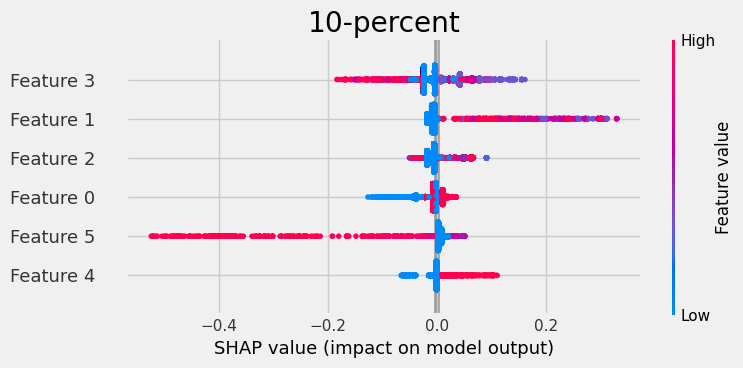

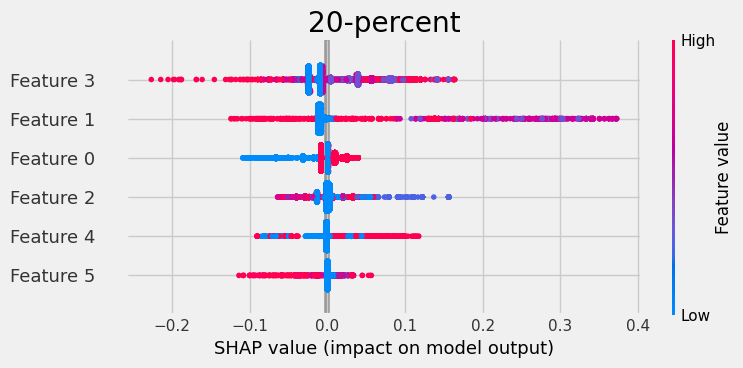

In [ ]:
import shap
import matplotlib.pyplot as plt

# learner_t.estimate_ate(X_train , T_train, Y_train)
tlearner_tau = learner_t.fit_predict(X_train , T_train, Y_train)
shap_values = learner_t.get_shap_values(X=X_train, tau=tlearner_tau) # Get SHAP values

# Remove feature_names argument here as it's likely already set internally
learner_t.plot_shap_values(X=X_train, shap_dict=shap_values) # Pass SHAP values to plot function

In [ ]:
import shap
import matplotlib.pyplot as plt

# learner_t.estimate_ate(X_train , T_train, Y_train)
tlearner_tau = learner_t.fit_predict(X_train , T_train, Y_train)
shap_values = learner_t.get_shap_values(X=X_train, tau=tlearner_tau) # Get SHAP values

learner_t.plot_shap_values(X=X_train, shap_dict=shap_values) # Pass SHAP values to plot function

In [ ]:
def predict_multi(df, learner, learner_name, X_test):
    """
    Predict treatment effects for multiple treatments and determine the best treatment.
    """

    cols = [f'{learner_name}_learner_{action}' for action in actions]

    # print(learner.predict(X=X_test).shape)

    df[cols] = learner.predict(X=X_test)

    df[f'{learner_name}_learner_effect'] = df[cols].max(axis=1)

    df[f"{learner_name}_best_treatment"] = df[cols].idxmax(axis=1)
    df.loc[df[f'{learner_name}_learner_effect'] < 0, f"{learner_name}_best_treatment"] = "zero" # E(Y0- Y1 | X)

    return df


for learner,learner_name in zip([rfc, learner_s, learner_t],['rf','learner_s','learner_t']):


    df_results_multi = predict_multi(df_test,learner,learner_name,X_test)
    df_results_multi = predict_multi(df_test, rfc, 'rf', X_test)
    df_results_multi = predict_multi(df_test, learner_s, 's', X_test)
    df_results_multi = predict_multi(df_test, learner_t, 't', X_test)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

In [ ]:
df_results_multi.columns

Index(['user_id', 'variant_name', 'sign_up_incentive', 'user_category',
       'loyalty_tier', 'overall_clicks', 'overall_orders', 'overall_revenue',
       'before_exposure_orders', 'after_exposure_orders',
       'before_exposure_revenue', 'after_exposure_revenue',
       'before_exposure_clicks', 'after_exposure_clicks',
       'order_conversion_7d', 'prev_clicks_7d', 'prev_clicks_14d',
       'next_clicks_7d', 'next_clicks_14d', 'prev_orders_7d',
       'prev_orders_14d', 'next_orders_7d', 'next_orders_14d',
       'prev_revenue_7d', 'prev_revenue_14d', 'next_revenue_7d',
       'next_revenue_14d', 'rf_learner_10-percent', 'rf_learner_20-percent',
       'rf_learner_effect', 'rf_best_treatment', 's_learner_10-percent',
       's_learner_20-percent', 's_learner_effect', 's_best_treatment',
       't_learner_10-percent', 't_learner_20-percent', 't_learner_effect',
       't_best_treatment', 'learner_s_learner_10-percent',
       'learner_s_learner_20-percent', 'learner_s_learner_effe

In [ ]:
df_results_multi.groupby(['variant_name'])['user_id'].count()

,user_id
variant_name,
10-percent,2034
20-percent,2013
zero,2101


In [ ]:
df_results_multi.head(1).T

,19803
user_id,501403
variant_name,20-percent
sign_up_incentive,0
user_category,0
loyalty_tier,0
overall_clicks,0
overall_orders,0
overall_revenue,NaN
before_exposure_orders,0
after_exposure_orders,0


In [ ]:
df_results_multi.groupby(['variant_name','t_best_treatment']).agg({'user_id':'count','learner_t_learner_effect': np.median}).reset_index()

,variant_name,t_best_treatment,user_id,learner_t_learner_effect
0,10-percent,t_learner_10-percent,335,0.065142
1,10-percent,t_learner_20-percent,382,0.024960
2,10-percent,zero,1317,-0.035007
3,20-percent,t_learner_10-percent,323,0.065142
4,20-percent,t_learner_20-percent,355,0.024960
5,20-percent,zero,1335,-0.035007
6,zero,t_learner_10-percent,342,0.065142
7,zero,t_learner_20-percent,393,0.024960
8,zero,zero,1366,-0.035007


In [ ]:
display(df_results_multi[["rf_learner_effect",
                         "s_learner_effect","t_learner_effect",
                        #  "order_conversion_7d",
                        #  "variant_name"
                         ]].mean())

df_multi_results_plot = df_results_multi[["rf_learner_effect",
                         "s_learner_effect","t_learner_effect",
                         "order_conversion_7d",
                         "variant_name","rf_best_treatment"
                         ]].copy()


,0
rf_learner_effect,0.016165
s_learner_effect,0.053872
t_learner_effect,0.010562


In [ ]:
# df_multi_results_plot[['t_learner_effect','variant_name_numeric','order_conversion_7d']].head()

AAUC Score Normalized: t_learner_effect    0.582519
Random              0.465149
dtype: float64
AAUC Score: t_learner_effect    55.301432
Random              44.158936
dtype: float64


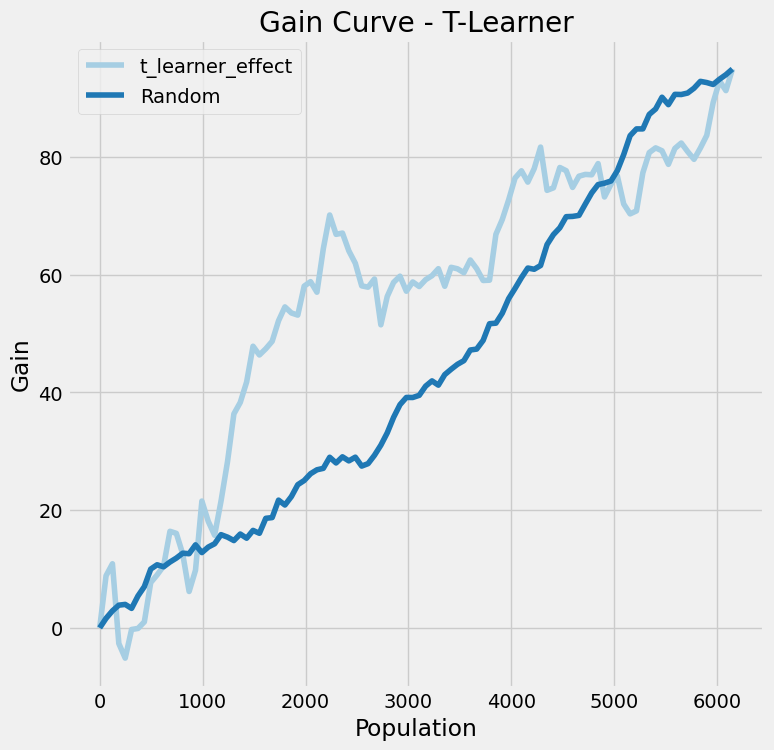

<Figure size 640x480 with 0 Axes>

In [ ]:
from causalml.metrics import plot_gain
from causalml.metrics import auuc_score


variant_mapping = {'zero': 0, '10-percent': 1, '20-percent': 1}

df_multi_results_plot['variant_name_numeric'] = df_multi_results_plot['variant_name'].apply(lambda x: variant_mapping[x]).astype(int)

df_multi_results_plot_ = df_multi_results_plot[df_multi_results_plot['variant_name_numeric'].isin([0,1])]
aauc_normalized = auuc_score(df_multi_results_plot_[['t_learner_effect','variant_name_numeric','order_conversion_7d']],
                             outcome_col='order_conversion_7d',
                             treatment_col='variant_name_numeric',
                            #  treatment_effect_col='t_learner_effect',
                             normalize=True, tmle=False)
aauc_non_normalize = auuc_score(df_multi_results_plot_[['t_learner_effect','variant_name_numeric','order_conversion_7d']],
                                outcome_col='order_conversion_7d',
                                treatment_col='variant_name_numeric',
                                # treatment_effect_col='t_learner_effect',
                                normalize=False, tmle=False)
print(f"AAUC Score Normalized: {aauc_normalized}")
print(f"AAUC Score: {aauc_non_normalize}")

plot_gain(df_multi_results_plot_[['t_learner_effect','variant_name_numeric','order_conversion_7d']],
          outcome_col='order_conversion_7d', treatment_col='variant_name_numeric',
          )
plt.title('Gain Curve - T-Learner')
plt.show()

plt.savefig('my_plot.png')

In [ ]:

importances = rfc.feature_importances_

importances

array([0.10999199, 0.15406204, 0.297677  , 0.32756051, 0.05020277,
       0.06050569])

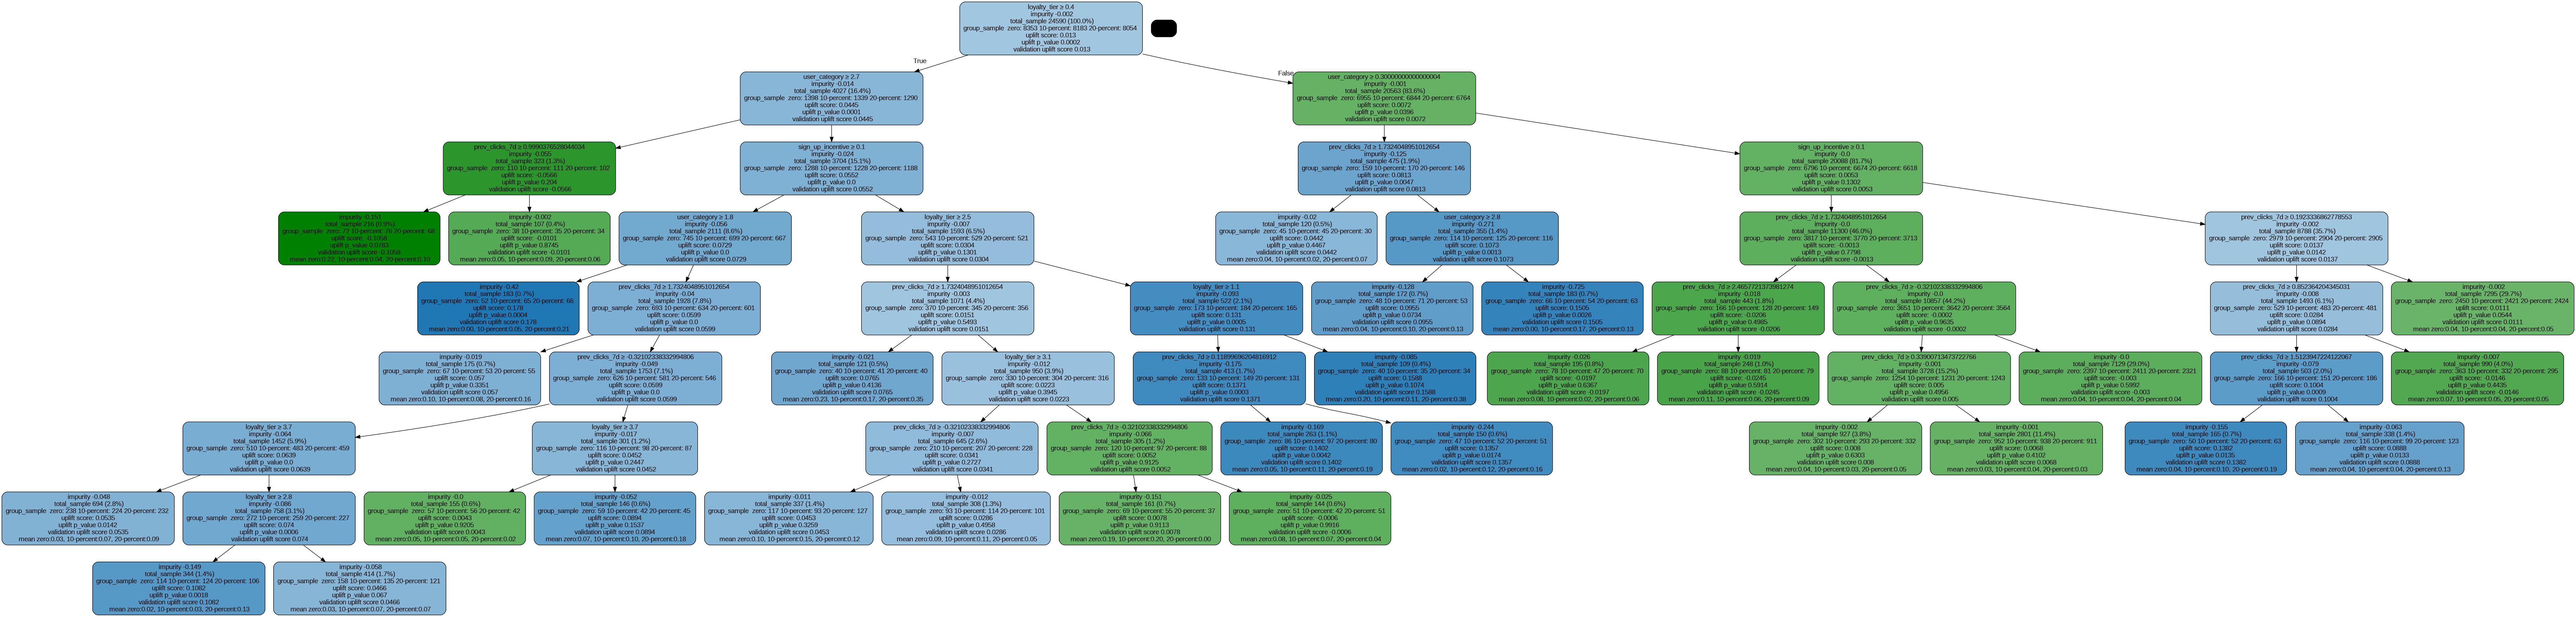

In [ ]:
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

uplift_tree = rfc.uplift_forest[0]
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,feature_columns)
Image(graph.create_png())

In [ ]:
# Using Retrospective Estimation  for improving ROI for converted Users while considering ROI and Coupon cost


from xgboost import XGBClassifier


In [ ]:
df.groupby(['variant_name','order_conversion_7d'])['user_id'].count()

variant_name  order_conversion_7d
10-percent    0                      9781
              1                       506
20-percent    0                      9501
              1                       619
zero          0                      9873
              1                       458
Name: user_id, dtype: int64

In [ ]:
converted_users = df[df['order_conversion_7d'] == 1]


# S(x) = P(T=1 | X, Y=1) I am basically trying to understand Probability that a converted user was in treatment given X features
feature_columns = [
       'sign_up_incentive', 'user_category', 'loyalty_tier',
        'before_exposure_orders',
         'before_exposure_revenue',
         'before_exposure_clicks',
       'prev_clicks_7d',
        'prev_orders_7d',
       'prev_revenue_7d','prev_orders_14d','prev_orders_14d']

le = LabelEncoder()
converted_users['sign_up_incentive'] = le.fit_transform(converted_users['sign_up_incentive'])
converted_users['user_category'] = le.fit_transform(converted_users['user_category'])
converted_users['loyalty_tier'] = le.fit_transform(converted_users['loyalty_tier'])

# converted_users['before_exposure_orders'] = converted_users['before_exposure_orders'].fillna(0)
# converted_users['before_exposure_revenue'] = converted_users['before_exposure_revenue'].fillna(0)
# converted_users['before_exposure_clicks'] = converted_users['before_exposure_clicks'].fillna(0)


converted_users['prev_clicks_7d'] = converted_users['prev_clicks_7d'].fillna(0)
df_results_multi['prev_clicks_14d'] = df_results_multi['prev_clicks_14d'].fillna(0)
converted_users['prev_orders_7d'] = converted_users['prev_orders_7d'].fillna(0)
df_results_multi['prev_orders_14d'] = df_results_multi['prev_orders_14d'].fillna(0)
converted_users['prev_revenue_7d'] = converted_users['prev_revenue_7d'].fillna(0)

# converted_users['prev_clicks_7d'] = scaler.fit_transform(converted_users['prev_clicks_7d'].values.reshape(-1, 1))
# converted_users['prev_clicks_7d'] = scaler.fit_transform(converted_users['prev_clicks_7d'].values.reshape(-1, 1))
# converted_users['prev_orders_7d'] = scaler.fit_transform(converted_users['prev_orders_7d'].values.reshape(-1, 1))
# converted_users['prev_revenue_7d'] = scaler.fit_transform(converted_users['prev_revenue_7d'].values.reshape(-1, 1))

# converted_users['prev_clicks_14d'] = scaler.fit_transform(converted_users['prev_clicks_14d'].values.reshape(-1, 1))
# converted_users['prev_orders_14d'] = scaler.fit_transform(converted_users['prev_orders_14d'].values.reshape(-1, 1))


converted_users = pd.get_dummies(converted_users, columns=['variant_name'], prefix='T')


# # Train models to estimate S_T(x) for each treatment
treatments = ['T_zero','T_10-percent', 'T_20-percent']
models = {}


for treatment in treatments:
    y = converted_users[treatment].values
    X = converted_users[feature_columns].values
    model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree= 0.5,
    gamma=0,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=50,
    subsample=0.5
    )
    model.fit(X, y)
    models[treatment] = model
    converted_users[f'S_{treatment}'] = model.predict_proba(X)[:, 1]  # Store S_T(x)

costs = {'T_zero': 0, 'T_10-percent': 15, 'T_20-percent': 30}  # Estimated coupon cost, not including shipping cost
# revenue = 156 # revenue for converted users in 7 days post exposure
revenue = {'T_zero': 151, 'T_10-percent': 154, 'T_20-percent': 156}
cr = {'T_zero': 0.04433, 'T_10-percent': 0.04919, 'T_20-percent': 0.06117}


for treatment in treatments:
    S_x = converted_users[f'S_{treatment}']
    cost = costs[treatment]
    # revenue = revenue[treatment]
    converted_users[f'uplift_{treatment}'] = (2 * S_x - 1) / (
        S_x * ((cost * cr[treatment]) - revenue[treatment]) + (1 - S_x) * revenue[treatment]
    )

uplift_cols = [f'uplift_{t}' for t in treatments]
converted_users['best_treatment'] = converted_users[uplift_cols].idxmax(axis=1)  # Choose the treatment with max uplift
converted_users['best_treatment'] = converted_users['best_treatment'].str.replace('uplift_', '')  # Clean up column names



def evaluate_uplift_multi(positive_data):

    results = []
    for treatment in treatments:
        subset = positive_data[positive_data['best_treatment'] == treatment]
        conversion_rate = subset['order_conversion_7d'].mean()
        results.append((treatment, conversion_rate, len(subset)))

    print("Treatment Results:")
    for treatment, conversion_rate, count in results:
        print(f"Treatment {treatment}: Conversion Rate = {conversion_rate:.4f}, Users = {count}")


evaluate_uplift_multi(converted_users)



Treatment Results:
Treatment T_zero: Conversion Rate = nan, Users = 0
Treatment T_10-percent: Conversion Rate = nan, Users = 0
Treatment T_20-percent: Conversion Rate = 1.0000, Users = 1583


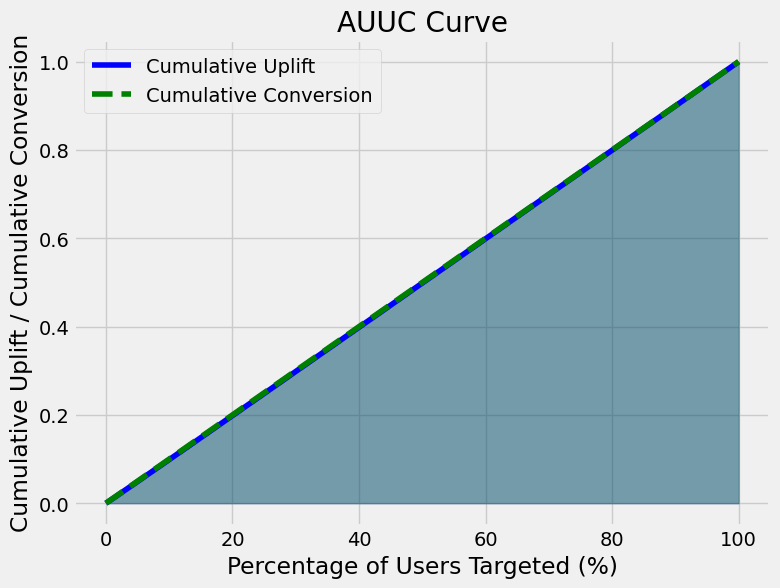

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

uplift_cols = ['uplift_T_zero', 'uplift_T_10-percent', 'uplift_T_20-percent']
converted_users['max_uplift'] = converted_users[uplift_cols].max(axis=1)

sorted_data = converted_users.sort_values(by='max_uplift', ascending=False)

cumulative_uplift = []
cumulative_conversion = []
num_users = len(sorted_data)
total_conversion = sorted_data['order_conversion_7d'].sum()

for k in range(1, num_users + 1):
    subset = sorted_data.iloc[:k]
    cumulative_conversion.append(subset['order_conversion_7d'].sum())
    cumulative_uplift.append(subset['max_uplift'].sum())

# Normalize cumulative values to get the AUUC curve
cumulative_uplift = np.array(cumulative_uplift) / cumulative_uplift[-1]
cumulative_conversion = np.array(cumulative_conversion) / total_conversion

# Plot AUUC Curve
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 100, num_users), cumulative_uplift, label="Cumulative Uplift", color='blue')
plt.plot(np.linspace(0, 100, num_users), cumulative_conversion, label="Cumulative Conversion", color='green', linestyle='--')

# AUUC (Area Under the Uplift Curve) is the area under the 'Cumulative Uplift' curve
plt.fill_between(np.linspace(0, 100, num_users), cumulative_uplift, alpha=0.3, color='blue')
plt.fill_between(np.linspace(0, 100, num_users), cumulative_conversion, alpha=0.3, color='green')

plt.xlabel("Percentage of Users Targeted (%)")
plt.ylabel("Cumulative Uplift / Cumulative Conversion")
plt.title("AUUC Curve")
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


# Split data into treated and control groups
treated_data = converted_users[converted_users['treatment'] > 0]  # Users who received treatment (10% or 20%)
control_data = converted_users[converted_users['treatment'] == 0]  # Users who received no treatment (0%)

# Prepare features (X) and target (y) for both groups
X_treated = treated_data[['feature_1', 'feature_2']]
y_treated = treated_data['converted']

X_control = control_data[['feature_1', 'feature_2']]
y_control = control_data['converted']

# Initialize the models for treatment and control
model_treatment = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_control = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train models for both groups
model_treatment.fit(X_treated, y_treated)
model_control.fit(X_control, y_control)

# Predict conversion probabilities for both models
prob_treatment = model_treatment.predict_proba(data[['feature_1', 'feature_2']])[:, 1]
prob_control = model_control.predict_proba(data[['feature_1', 'feature_2']])[:, 1]

# Calculate the uplift score (difference between treatment and control probabilities)
uplift_score = prob_treatment - prob_control

# Add the uplift score to the data
data['uplift_score'] = uplift_score

# Determine the best treatment based on the highest uplift score
data['best_treatment'] = np.select(
    [data['uplift_score'] > 0, data['uplift_score'] <= 0],
    [data['treatment'], 0],  # Assign treatment where uplift is positive, otherwise control group
    default=0
)

# Show the first few rows with the assigned best treatment
print(data[['user_id', 'treatment', 'best_treatment', 'uplift_score']].head())



NameError: name 'uplift_score' is not defined

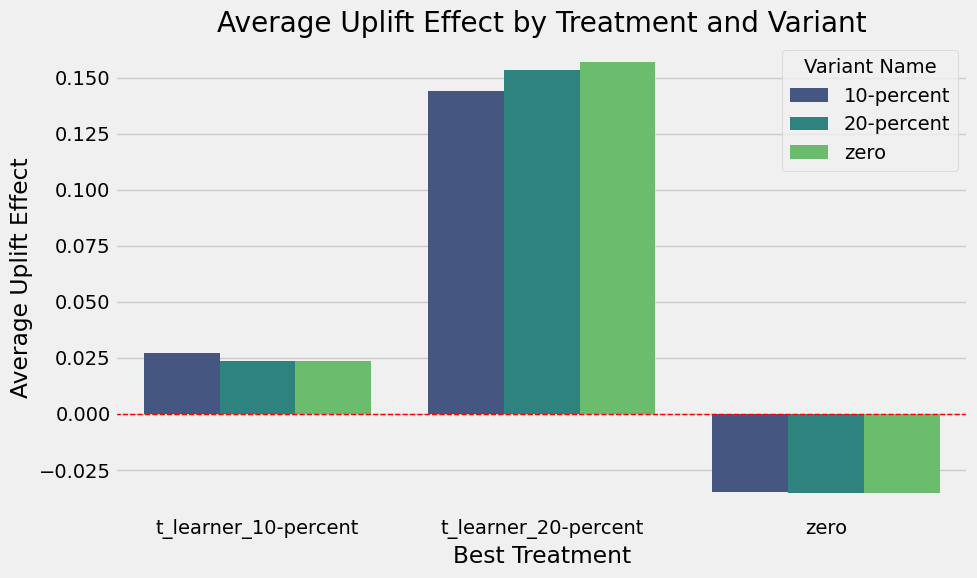

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
data = {
    'variant_name': ['10-percent', '10-percent', '10-percent', '20-percent', '20-percent', '20-percent', 'zero', 'zero', 'zero'],
    't_best_treatment': ['t_learner_10-percent', 't_learner_20-percent', 'zero', 't_learner_10-percent', 't_learner_20-percent', 'zero', 't_learner_10-percent', 't_learner_20-percent', 'zero'],
    'learner_t_learner_effect': [0.027264, 0.144075, -0.034637, 0.023584, 0.153500, -0.035046, 0.023717, 0.157029, -0.035263]
}

df = pd.DataFrame(data)

# Group Data by Variant Name and Best Treatment
grouped = df.groupby(['variant_name', 't_best_treatment'])['learner_t_learner_effect'].mean().reset_index()

# Visualization 1: Bar Plot for Average Uplift by Best Treatment
plt.figure(figsize=(10, 6))
sns.barplot(
    data=grouped,
    x='t_best_treatment',
    y='learner_t_learner_effect',
    hue='variant_name',
    palette='viridis'
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a zero reference line
plt.title('Average Uplift Effect by Treatment and Variant')
plt.ylabel('Average Uplift Effect')
plt.xlabel('Best Treatment')
plt.legend(title='Variant Name')
plt.tight_layout()
plt.show()

# df_results_multi.groupby(['variant_name','t_best_treatment']).agg({'user_id':'count','learner_t_learner_effect': np.median}).reset_index()
# Visualization 2: Scatter Plot of Uplift for Each User
# plt.figure(figsize=(12, 6))
# sns.scatterplot(
#     data=df_results_multi,
#     x='t_best_treatment',
#     y='learner_t_learner_effect',
#     hue='variant_name',
#     style='variant_name',
#     palette='deep',
#     s=100
# )
# plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a zero reference line
# plt.title('Uplift Effect for Individual Users by Treatment')
# plt.ylabel('Uplift Effect')
# plt.xlabel('Best Treatment')
# plt.legend(title='Variant Name')
# plt.tight_layout()
# plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(learner_t, X_train)

# shap_values = explainer(X_train)

# shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)

# shap.summary_plot(shap_values, X_train, show=True)




TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: BaseTRegressor(model_c=LGBMRegressor(boosting_type='dart', class_weight='balanced', max_bin=32,
              max_depth=3, min_data_in_leaf=20, random_state=42), model_t=LGBMRegressor(boosting_type='dart', class_weight='balanced', max_bin=32,
              max_depth=3, min_data_in_leaf=20, random_state=42))